# Polynomial regression approach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
import pandas as pd
from osgeo import gdal,ogr,osr
import cuml
from cuml.decomposition import PCA

import cudf

print(f"{cudf.__version__=}")

cudf.__version__='24.10.01'


In [2]:
# Load image
img_file = "/home/patang/Documents/GitHub/UWW200_Master_Thesis_public/MasterThesisPythonCode/data/ang20180729t212542rfl/data/rectified/ang20180729t212542_rfl_v2r2_img_rectified"
img = gdal.Open(img_file)
img_array = img.ReadAsArray()
# Generate mask of valid pixels (True = valid, False = invalid)
valid_mask = (img_array[0] != -9999)  # Assuming -9999 is the no-data value
# Replace -9999 with nan
img_array = np.where(img_array == -9999, np.nan, img_array)

# read a few key properties of the image
img_nbands = img.RasterCount
img_ncols = img.RasterXSize
img_nrows = img.RasterYSize

print("\n".join(["Bands:\t"+str(img_nbands),"Cols (x-axis):\t"+str(img_ncols),"Rows (y-axis):\t"+str(img_nrows)]))

/home/patang/anaconda3/envs/rapids-24.10/lib/python3.12/site-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Bands:	425
Cols (x-axis):	1581
Rows (y-axis):	3694


In [3]:
# Load mask
mask_file = "/home/patang/Documents/GitHub/UWW200_Master_Thesis_public/MasterThesisPythonCode/data/ang20180729t212542rfl/mask/ang20180729t212542_rfl_v2r2_img_rectified_savi_mask_02"
mask = gdal.Open(mask_file)
mask_array = mask.ReadAsArray()

# read a few key properties of the image
mask_nbands = img.RasterCount
mask_ncols = img.RasterXSize
mask_nrows = img.RasterYSize

print("\n".join(["Bands:\t"+str(mask_nbands),"Cols (x-axis):\t"+str(mask_ncols),"Rows (y-axis):\t"+str(mask_nrows)]))

Bands:	425
Cols (x-axis):	1581
Rows (y-axis):	3694


In [4]:
# Create a binary mask where valid pixels are 1, and no-data (255) is 0
binary_mask = (mask_array != 255).astype(np.uint8)  # 1 for valid, 0 for no-data

# Apply the mask to the image
# Broadcast the mask over all bands
masked_img = img_array * binary_mask  # Retains only valid pixels

In [5]:
masked_img.shape

(425, 3694, 1581)

In [6]:
# Flatten the valid pixels
# First reshape the image array: (bands, height, width) -> (height * width, bands)
bands, rows, cols = masked_img.shape
reshaped_masked_img = masked_img.reshape(bands, rows * cols).T

In [7]:
rows

3694

In [8]:
# Filter out invalid pixels based on the mask
valid_pixels = reshaped_masked_img[~np.isnan(reshaped_masked_img).any(axis=1)]  # Only rows with no NaN

In [9]:
# Load Data (Assume `data` is a NumPy array)
# Standardize Data
pca_input_data = (valid_pixels - np.mean(valid_pixels, axis=0)) / np.std(valid_pixels, axis=0)

In [10]:
pca_input_data

array([[ 3.7532492 ,  4.266729  ,  3.946425  , ...,  0.66637194,
         0.63001764, -0.8062764 ],
       [ 1.8330873 ,  2.4535015 ,  2.3053617 , ...,  0.60120785,
         0.8507235 , -0.8062764 ],
       [ 5.954866  ,  3.5210166 ,  4.1541224 , ...,  1.3192204 ,
         0.6924357 , -0.8062764 ],
       ...,
       [-0.8933457 , -0.9160797 , -0.9959891 , ..., -1.0945829 ,
        -1.0628765 ,  1.2489816 ],
       [-0.8933457 , -0.9160797 , -0.9959891 , ..., -1.0945829 ,
        -1.0628765 ,  1.2489816 ],
       [-0.8933457 , -0.9160797 , -0.9959891 , ..., -1.0945829 ,
        -1.0628765 ,  1.2489816 ]], dtype=float32)

In [11]:
# Dimensionality Reduction with GPU PCA
pca = PCA(n_components=30)
reduced_data = pca.fit_transform(pca_input_data)

# Print explained variance for each component
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance by each component: {explained_variance}")
print(f"Total explained variance: {explained_variance.sum()}")

Explained variance by each component: [9.5903844e-01 2.0974807e-02 8.9324387e-03 3.3834986e-03 2.3395244e-03
 2.1383914e-03 1.6690084e-03 1.2292929e-03 8.9268025e-04 7.6827995e-04
 6.5135694e-04 5.3405494e-04 4.9397873e-04 4.8368453e-04 4.5464467e-04
 4.3436445e-04 4.0675636e-04 3.8833136e-04 3.6144190e-04 3.3792228e-04
 3.1563829e-04 2.9436572e-04 2.8225398e-04 2.6323850e-04 2.5443180e-04
 2.4352787e-04 2.4005988e-04 2.2105410e-04 2.1390240e-04 2.0419352e-04]
Total explained variance: 1.0084455013275146


In [13]:
# Initialize empty array for PCA-reconstructed image
reconstructed_img = np.full((pca.n_components, rows, cols), np.nan)

# Assign PCA-transformed values to valid pixel locations
for i in range(pca.n_components):
    #component_data = np.zeros(valid_mask.shape)  # Start with zeros or NaN
    component_data = np.full(valid_mask.shape, np.nan)   # Start with zeros or NaN
    component_data[valid_mask] = reduced_data[:, i]  # Fill valid pixels
    reconstructed_img[i] = component_data

In [14]:
reconstructed_img.shape

(30, 3694, 1581)

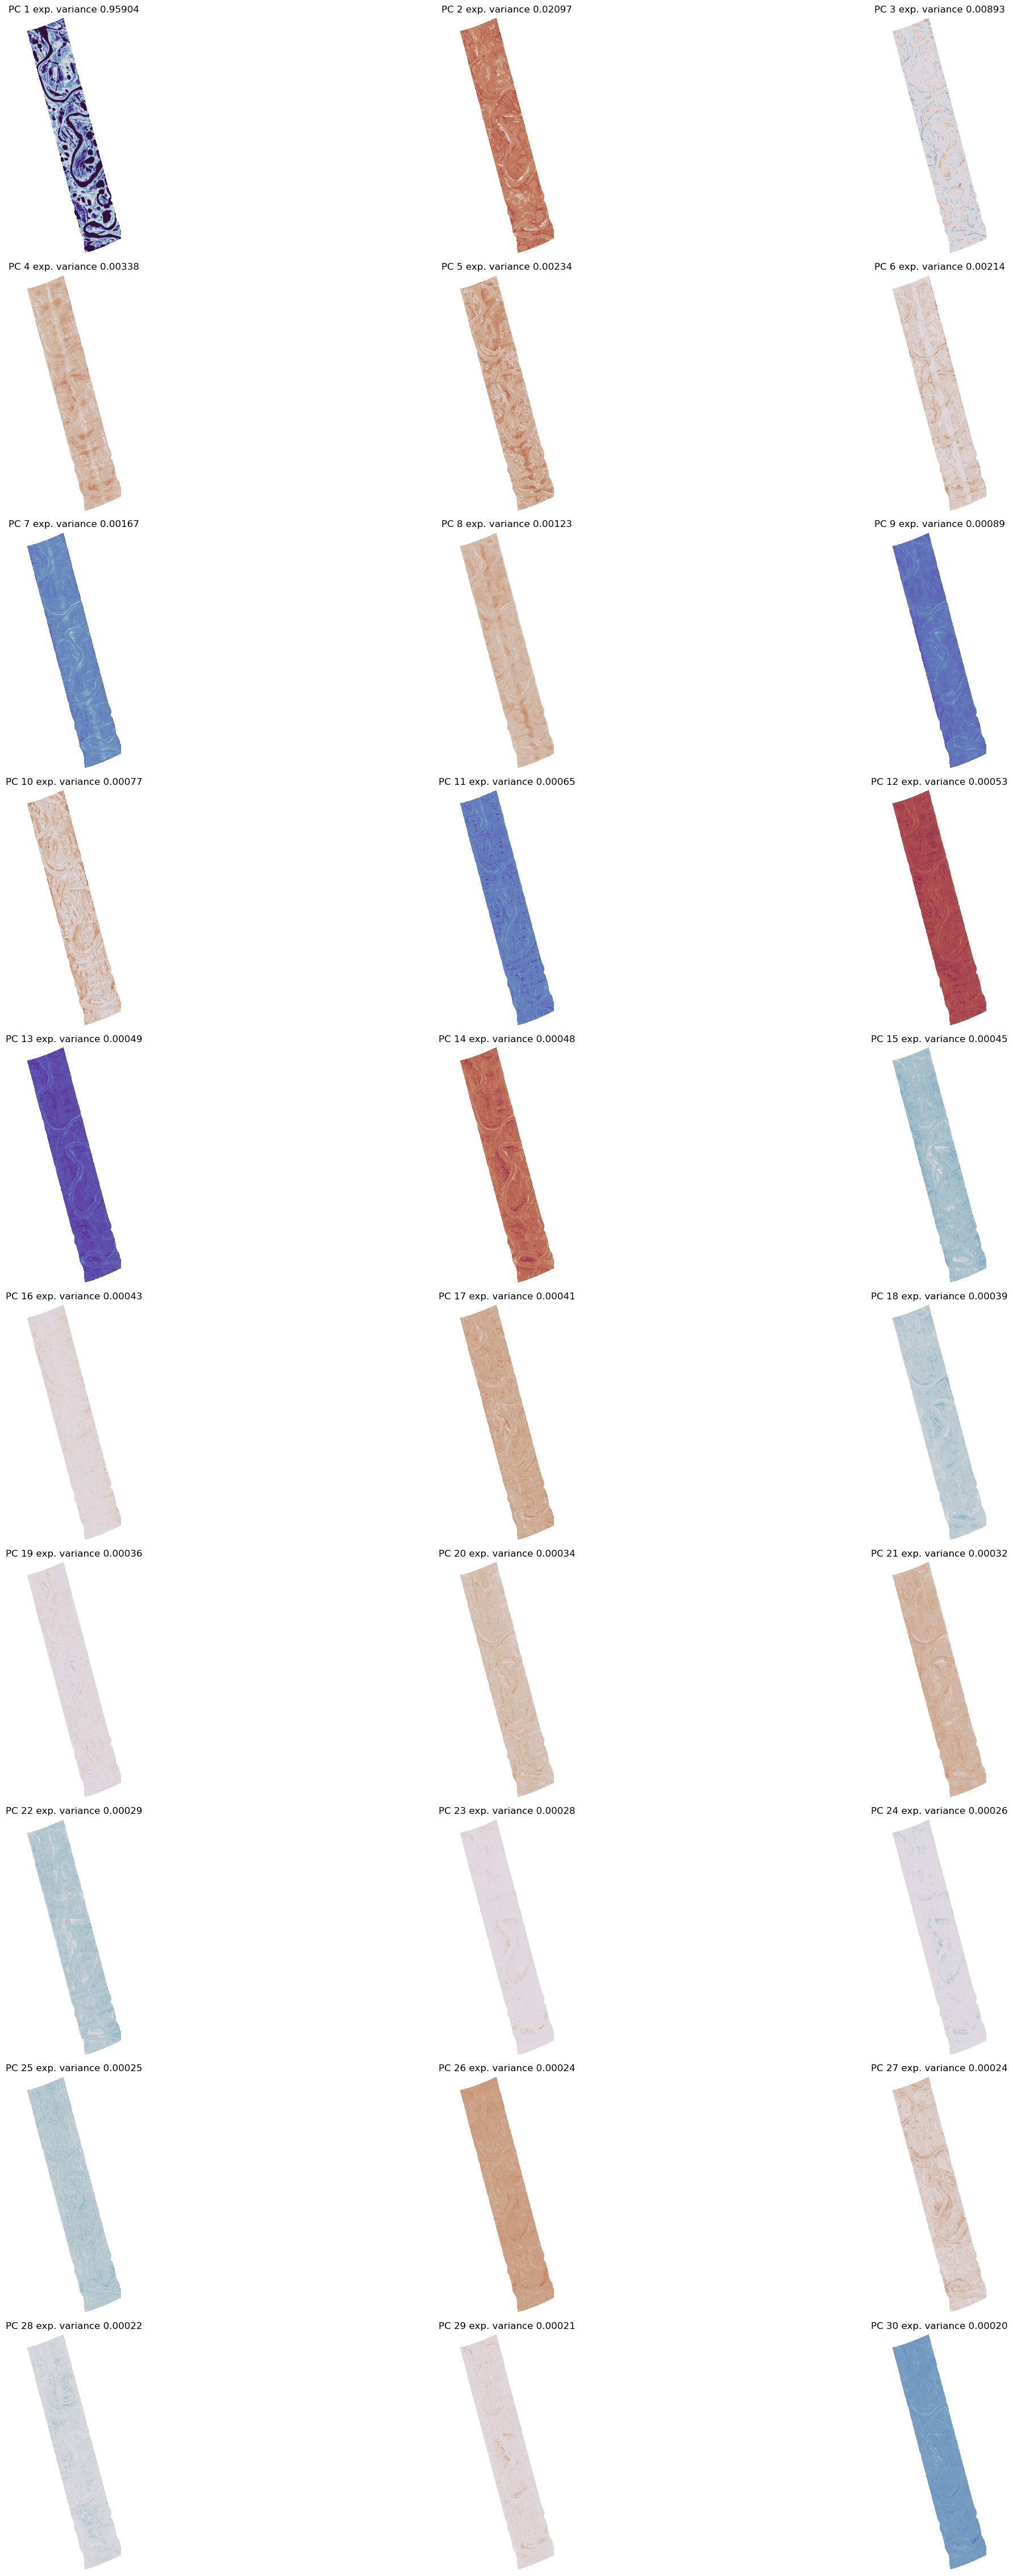

In [18]:
plot_all_pcs = True

if plot_all_pcs:
    # Assuming 'reconstructed_img' is of shape (num_components, rows, cols)
    num_components, rows, cols = reconstructed_img.shape

    # Set up the number of rows and columns for the subplots
    rows_for_plots = (num_components // 3) + 1
    fig, axes = plt.subplots(nrows=rows_for_plots, ncols=3, figsize=(23, 50))

    # Flatten the axes array for easier indexing
    axes = axes.flatten()

    for i in range(num_components):
        ax = axes[i]
        
        # Normalize the component for display to the range [0, 1]
        component_normalized = (reconstructed_img[i] - np.nanmin(reconstructed_img[i])) / (np.nanmax(reconstructed_img[i]) - np.nanmin(reconstructed_img[i]))
        
        # Handle NaN values by masking them
        component_normalized = np.ma.masked_where(np.isnan(component_normalized), component_normalized)
        
        ax.imshow(component_normalized, cmap='twilight_shifted')
        
        # Assuming 'explained_variance' is available as a list of explained variances for each component
        expl_variance = "%.5f" % explained_variance[i]  # Format to 5 decimal places
        ax.set_title(f"PC {i + 1} exp. variance {expl_variance}")
        ax.axis("off")  # Hide axis

    # Remove any empty subplots if there are fewer axes than components
    for j in range(num_components, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()


In [16]:
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components that explain at least 99% variance
threshold = 0.99
num_components = np.argmax(explained_variance_ratio >= threshold) + 1  # +1 because indices start from 0

# Select the top `num_components` principal components
selected_pcs = list(range(num_components))

print(f'PCs selected: {selected_pcs}')

# Select the corresponding PCA images
pca_image_selection = reconstructed_img[selected_pcs, :, :]

PCs selected: [0, 1, 2, 3]


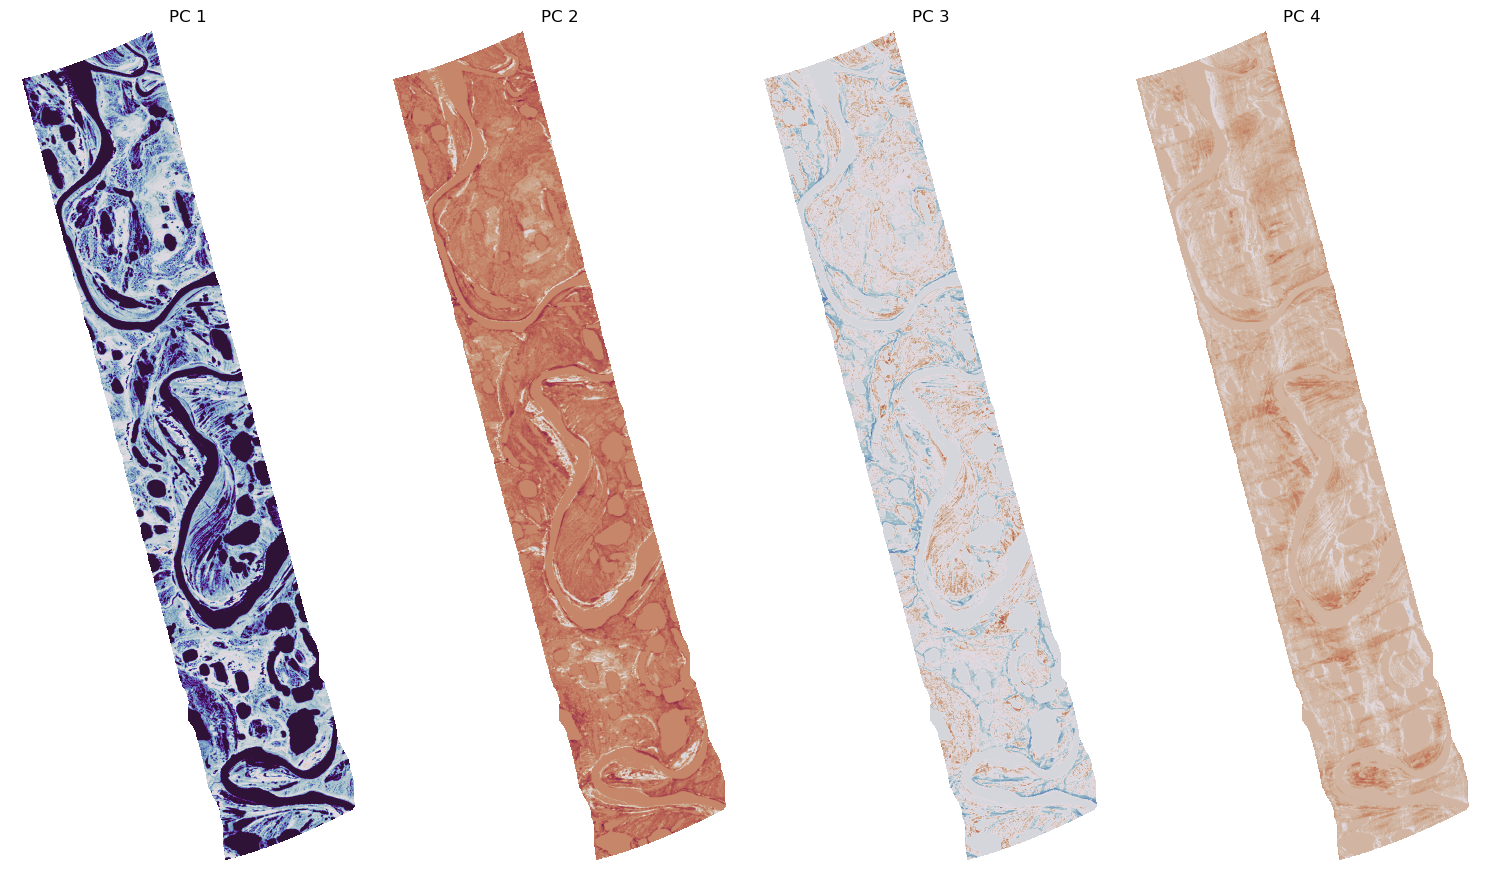

In [17]:
# To visualize the selected PCs
fig, axes = plt.subplots(1, len(selected_pcs), figsize=(15, 15))
for i, pc_index in enumerate(selected_pcs):
    ax = axes[i]
    ax.imshow(pca_image_selection[pc_index, :, :], cmap='twilight_shifted')
    ax.set_title(f'PC {pc_index + 1}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [23]:
# Define Range of Clusters
k_values = range(2, 15)

selected_kmeans_data = reconstructed_img[selected_pcs, :, :].reshape(len(selected_pcs), -1).T
valid_kmeans_data = selected_kmeans_data[~np.isnan(selected_kmeans_data).any(axis=1)]


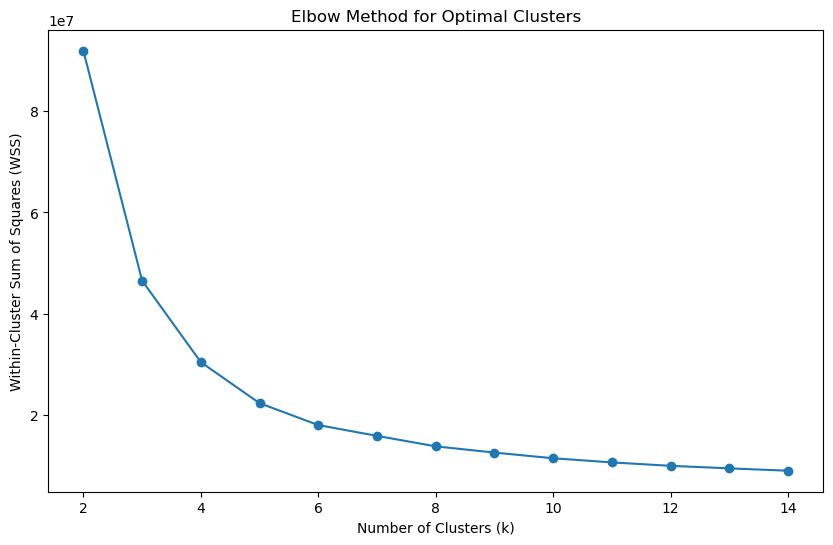

Optimal number of clusters (Elbow Method): 14


In [24]:
# Compute WSS (Elbow Method) using GPU-accelerated KMeans
wss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(valid_kmeans_data)
    wss.append(kmeans.inertia_)

# Plot WSS for Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_values, wss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

# Determine Optimal K (Elbow Point)
optimal_k = k_values[np.argmin(np.gradient(np.gradient(wss)))]
print(f"Optimal number of clusters (Elbow Method): {optimal_k}")

# Perform Final Clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_final.fit(valid_kmeans_data)

# Access Cluster Labels
cluster_labels = kmeans_final.labels_

# Optionally, save cluster labels or further analyze
np.save('cluster_labels.npy', cluster_labels)

In [51]:
# Reshape the PCA components data into a 2D array (num_pixels, num_components)
num_components, rows, cols = pca_image_selection.shape
reshaped_data_kmeans_final_clustering = pca_image_selection.reshape(num_components, -1).T  # Shape: (num_pixels, num_components)
# Step 2: Remove rows with NaN values
# You can use np.isnan to identify rows with NaN values, and then filter them out.
cleaned_data_kmeans_final_clustering = reshaped_data_kmeans_final_clustering[~np.isnan(reshaped_data_kmeans_final_clustering).any(axis=1)]

In [62]:
# Step 2: Transfer data to GPU using cuDF (GPU DataFrame)
reshaped_data_gpu = cudf.DataFrame.from_records(cleaned_data_kmeans_final_clustering)
reshaped_data_gpu_cupy = reshaped_data_gpu.to_cupy()

In [64]:
type(reshaped_data_gpu_cupy)

cupy.ndarray

In [65]:
kmeans_float = KMeans(n_clusters=2)
kmeans_float.fit(reshaped_data_gpu_cupy)

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [42]:
# Step 3: Perform KMeans clustering on the GPU
kmeans = KMeans(n_clusters=14, random_state=42)  # 14 clusters as determined by your analysis

In [66]:
# Assuming you already have the reshaped PCA data
num_components, rows, cols = pca_image_selection.shape
reshaped_data_kmeans_final_clustering = pca_image_selection.reshape(num_components, -1).T  # Shape: (num_pixels, num_components)

# Step 2: Remove rows with NaN values (correct this part)
cleaned_data_kmeans_final_clustering = reshaped_data_kmeans_final_clustering[~np.isnan(reshaped_data_kmeans_final_clustering).any(axis=1)]

# Step 3: Transfer the cleaned data to GPU using cuDF (GPU DataFrame)
reshaped_data_gpu = cudf.DataFrame.from_records(cleaned_data_kmeans_final_clustering)

# Step 4: Convert the cuDF DataFrame to cuPy array explicitly (not NumPy)
reshaped_data_gpu_cupy = reshaped_data_gpu.to_cupy()

# Step 5: Fit KMeans model using cuPy array
kmeans_float = KMeans(n_clusters=2, random_state=42)
kmeans_float.fit(reshaped_data_gpu_cupy)  # Fit the model to the cuPy data

# Step 6: Get the cluster labels
cluster_labels = kmeans_float.labels_

# Optionally, you can visualize or save the cluster labels
print(cluster_labels)

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [ ]:
 # Fit the model to the GPU data

KMeans(n_clusters=14, random_state=42)

array([4, 4, 9, ..., 1, 1, 1], dtype=int32)

In [47]:
# Step 4: Get the cluster labels and reshape them back to the image shape
cluster_labels = kmeans.labels_  # Cluster labels as a NumPy array
cluster_image = cluster_labels.reshape(rows, cols)  # Reshape to original image shape

# Step 5: Visualize the clustering result
plt.figure(figsize=(10, 8))
plt.imshow(cluster_image, cmap='tab20', interpolation='nearest')  # Display the clustered image
plt.colorbar(label='Cluster ID')
plt.title('GPU-accelerated KMeans Clustering of PCA Components (14 clusters)')
plt.axis('off')
plt.show()

ValueError: cannot reshape array of size 2220897 into shape (3694,1581)

In [ ]:
# Load Data (Assume `data` is a NumPy array)
# Standardize Data
data = (valid_pixels - np.mean(valid_pixels, axis=0)) / np.std(valid_pixels, axis=0)

# Dimensionality Reduction with GPU PCA
num_components = 30
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(data)

In [ ]:
# GPU-Accelerated K-Means
k_values = range(2, 15)
wss = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_result)
    wss.append(kmeans.inertia_)

# Determine Optimal K (Elbow Method)
optimal_k = k_values[np.argmin(np.gradient(np.gradient(wss)))]
print(f"Optimal number of clusters: {optimal_k}")